# Convolutional Neural Networks - The Basics
#### By Jonathan L. Moran (jo6155mo-s@student.lu.se)
From the EDAN95 - Applied Machine Learning course given at Lunds Tekniska Högskola (LTH) | Ht2 2019.

## Objectives
In this lab assignment, we will
* Build a simple Convolutional Neural Network
* Use Image Augmentation
* Use a Pretrained Convolutional Base with and without image augmentation

## Programming

### Collecting a dataset

For this image classification task, we will be using a popular multi-class classification dataset called the Flowers Recognition Kaggle dataset. This dataset consists of 4,242 low-resolution 2-D images each labeled with one of five flower types. 

A copy of the dataset can be obtained via Kaggle at the link [here](https://www.kaggle.com/alxmamaev/flowers-recognition).

In [ ]:
### Splitting the dataset
# Credit: https://github.com/pnugues/edan95/blob/master/labs/3.0-flowers_cnn_students.ipynb

In [5]:
"""
Categorising the flower dataset
Creating the dataset
Author: Pierre Nugues
"""
import os
from os import path
import random
import shutil

# The machine name (False if Colab)
vilde = False
# To create the same dataset
random.seed(0)
# Here write the path to your dataset
if vilde:
    base = '/home/jonathanmoran/'
else:
    base = 'src/'
original_dataset_dir = os.path.join(base, 'flowers_original')
dataset = os.path.join(base, 'flowers_split')
train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')
categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]
print(len(train_images))
print(len(val_images))
print(len(test_images))
for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)
for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)
for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

Image types: ['sunflower', 'tulip', 'rose', 'daisy', 'dandelion']
2590
863
864


The Flowers Recognition dataset consists of the following five class labels (flower types)

In [6]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
def set_variables(base):
    base_dir = base
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')
    return train_dir, validation_dir, test_dir

In [8]:
base_dir = 'src/flowers_split/'

In [9]:
train_dir, validation_dir, test_dir = set_variables(base_dir)

## Building a Simple Convolutional Neural Network
* Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the ImageDataGenerator class to scale your images as in the book:
        train_datagen = ImageDataGenerator(rescale=1. / 255)
        val_datagen = ImageDataGenerator(rescale=1. / 255)
        test_datagen = ImageDataGenerator(rescale=1. / 255)
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.
* Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.
* Try to improve your model by modifying some parameters and evaluate your network again.

In [10]:
# Model parameters
epochs = 20
batch_size = 128
target_size = (150, 150)

### Scaling our images

In order to prepare our data, the 2-D images, for use in our model, we have to first perform several pre-processing steps. This involves reading in our images in JPEG format, resizing them to 150x150px for faster processing, then converting their RGB pixel values into floating-point tensors. To help our neural network in the training process, we will also rescale pixel values from 0-255 to the same interval [0,1] for every image. This allows our images to contribute more evenly to the total loss (more on that [here](https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn/)).


To accomplish this task in real-time, the Keras `ImageDataGenerator` class will be used. 

In [11]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [12]:
def data_preprocessing():
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=target_size,
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')
    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
    return train_datagen, test_datagen, train_generator, validation_generator

Let's run our data generator and see how many images we have to process...

In [13]:
# Data preprocessing
train_datagen, test_datagen, train_generator, validation_generator = data_preprocessing()

Found 2590 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


Checking to make sure we've specified the right image size in our generator...

In [14]:
print('image dimensions:', train_generator.target_size)

image dimensions: (150, 150)


Futhermore, we can take a look at the output of our `train_generator` to verify our image dimensions and the batch size (number of images per batch):

In [15]:
for data, labels in train_generator:
    print("data batch shape: (# samples={}, width(px)={}, height(px)={}, channels={})".format(data.shape[0], data.shape[1], data.shape[2], data.shape[3]))
    print("labels batch shape: (# samples={}, # classes={})".format(labels.shape[0], labels.shape[1]))
    break

data batch shape: (# samples=128, width(px)=150, height(px)=150, channels=3)
labels batch shape: (# samples=128, # classes=5)


### Visualising class representation
Since our dataset consists of five different classes (flower types), we want to first visualise the number of samples for each output class. To do so, we can get the count of the unique samples (images) in each class from our training set, then plot the counts on a bar chart using a familiar Python library.

In [18]:
from collections import OrderedDict
import numpy as np

In [19]:
unique, counts = np.unique(train_generator.classes, return_counts=True)
vals = OrderedDict(zip(unique, counts))
class_counts = []
for i in range(5):
    class_counts.append(vals[i])

In [20]:
import matplotlib.pyplot as plt

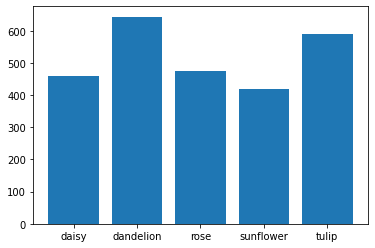

In [26]:
# Plotting class counts
plt.figure()
x = np.arange(len(class_counts))
plt.bar(x, class_counts)
xlabel = list(train_generator.class_indices.keys())
plt.xticks(x, xlabel)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


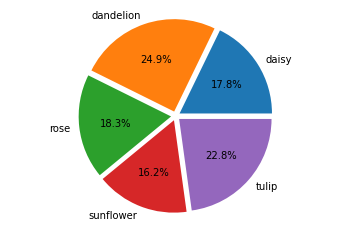

In [29]:
# Plotting class distributions
targets = [(counts)]
plt.pie(targets, labels=xlabel, explode=[0.05, 0.05, 0.05, 0.05, 0.05], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

### Visualising training performance

We'll use the following `plot_history()` method to visualise our model's training and validation accuracy and loss for each epoch. The input parameter is a History callback object which keeps track of the training metrics we want to visualise.

In [30]:
def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    # Plotting accuracy per epoch
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    # Plotting loss per epoch
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

### Building the network

The structure of our Convolutional Neural Network (CNN) is defined as a Keras `Sequential` model with a stack of alternating `Conv2D` and `MaxPooling2D` layers. At the core of our CNN is the `Conv2D` layer which transforms the input and outputs the transformation to the next layer. The tranformation performed in `Conv2D` is known as a _convolution operation_. In this operation, a filter is applied over the entire input in a sliding window protocol (from top-left to bottom-right of the matrix). The dot product is computed at each step and its resulting value is stored in the output channel. Once the filter has convolved the entire input, a new representation of our input is formed. This output channel is referred to as a feature map. Most commonly, a filter is applied over an input image to detect patterns such as edges, curves or textures. For a more complete understanding of the convolutional layer, read [this](https://deeplizard.com/learn/video/YRhxdVk_sIs) article.

The `MaxPooling2D` layer combination is used to reduce the dimensionality of the input (image) by reducing the number of pixels in the output from the previous convolutional layer. This reduces the amount of computation performed and the number of parameters to learn from the feature map.


To speed up our model training, we will use the `ReLU` (Rectified Linear Unit) activation function in our `Conv2D` layers. This function returns `0` if it receives any negative input, otherwise it will return the positve input value `x`. This function speeds up the gradient computation by setting any negative values to zero. For futher reading, see [this](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) article about ReLU on Keras.

In [31]:
from keras import layers
from keras import models
from keras import optimizers
from keras import metrics
from tensorflow.keras.utils import to_categorical

In [32]:
# Building our network (Conv2D/MaxPooling2D stack + Dense/Flatten layer)
def build_network():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # This converts our 3-D feature maps into 1-D feature vectors
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(len(classes), activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(), 
                  metrics =['categorical_accuracy'])
    return model

In [33]:
model = build_network()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

From the above model summary, we can see two things. One is that our feature map size decreases from 150x150 in our first `Conv2D` layer to 15x15 in our last `Conv2D` layer. Another is that the feature map depth increases from 32 to 128 as the network progresses. François Chollet–the creator of Keras, notes that this is a common pattern in almost all convnets.


The last layer in our model is specific to our task of multi-class classification. We expect a final layer of size 5, where each node corresponds to one of the five total classes (flower types). A `softmax` last-layer activation function is used to predict a multinomial probability distribution, or, in other words, the likelihood each image corresponds to one of the five possible target classes. The `softmax` constraint specifies that the sum of the five probability values must add up to 1.0. After our prediction, we will use the `argmax` function to "select" the most-likely class label (one with the greatest probability value) for each predicted sample in our output.

### Training the model

Now that we've built our first CNN, it's time to run it through our training data. In order to do that, we use the `keras.preprocessing.image` `ImageDataGenerator` class we specified earlier. The `fit_generator` method takes all the same parameters as a standard `fit` method aside from the first and most important one–the input `train_generator` object. This object "batches" our training data into pre-processed chunks, performing the resizing and normalising of our images according to the specifications we set at the start of this notebook. To be more precise about our other parameters, we must remember which `batch_size` we set for our `train_generator`. In our case, this was set to 128. This means that 128 images will be fetched from our training set directory, pre-processed, then fed into our network. During each epoch, we pass through every example in our training set. Thus, we must also specify the number of `steps_per_epoch` such that every training example is seen in each epoch for n number of batches. The following `np.ceil` calculation helps you in determining that amount.

In [34]:
def train_model(model, epochs=1):    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size))
    plot_history(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
21/21 [==============================] - 55s 497ms/step - loss: 2.2696 - categorical_accuracy: 0.2717 - val_loss: 1.3862 - val_categorical_accuracy: 0.3893
Epoch 2/20
21/21 [==============================] - 9s 424ms/step - loss: 1.3096 - categorical_accuracy: 0.4251 - val_loss: 1.2477 - val_categorical_accuracy: 0.5087
Epoch 3/20
21/21 [==============================] - 9s 423ms/step - loss: 1.2210 - categorical_accuracy: 0.4956 - val_loss: 1.1674 - val_categorical_accuracy: 0.5377
Epoch 4/20
21/21 [==============================] - 9s 416ms/step - loss: 1.1635 - categorical_accuracy: 0.5424 - val_loss: 1.0487 - val_categorical_accuracy: 0.5944
Epoch 5/20
21/21 [==============================] - 9s 423ms/step - loss: 1.0198 - categorical_accuracy: 0.5894 - val_loss: 1.0173 - val_categorical_accuracy: 0.5840
Epoch 6/20
21/21 [==============================] - 9s 432ms/step - loss: 0.9581 - categorical_accuracy: 0.6158 - val_loss: 0.9551 - val_categorical_accuracy: 0.6165
Epo

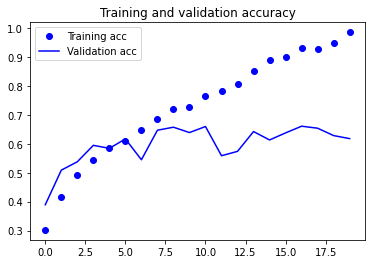

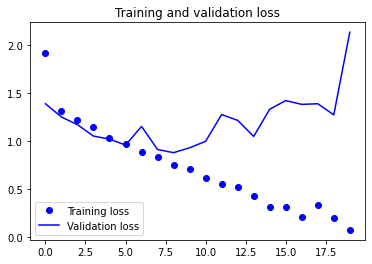

In [35]:
train_model(model, epochs)

For a simple Convolutional Neural Network, our initial results don't look all that bad! However, examining the plots a bit closer we see that the validation accuracy reaches a maximum around the 10th epoch. We also see that our validation loss reaches a minimum around the 7th epoch. Conversely, our training loss appears to decrease linearly until it reaches 0. This is characteristic of overfitting.


Why does this behavior occur? Well, a simple answer is that the number of training samples we have (~2000) is relatively few. In order to combat overfitting, there are many popular techniques from adding Dropout layers to penalising our model's weights with weight decay (L2 regularisation). Another technique specific to computer vision is _data augmentation_. We'll be using this in our next model to improve our results.

### Evaluating model performance

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [37]:
def evaluate_model(model):  
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    y_prob = model.predict_generator(test_generator, np.ceil(test_generator.samples / test_generator.batch_size))
    # Select greatest class probability for each sample in y_prob
    y_pred = np.argmax(y_prob, axis=1)
    print('-'*10 + 'Classification Report' + '-'*5)
    print(classification_report(test_generator.classes, y_pred, target_names=classes))
    print('-'*10 + 'Confusion Matrix' + '-'*10)
    plot_confusion_matrix(confusion_matrix(test_generator.classes, y_pred))

Found 864 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


----------Classification Report-----
              precision    recall  f1-score   support

       daisy       0.63      0.60      0.62       139
   dandelion       0.68      0.80      0.74       209
        rose       0.73      0.22      0.34       151
   sunflower       0.71      0.75      0.73       166
       tulip       0.58      0.77      0.66       199

    accuracy                           0.65       864
   macro avg       0.67      0.63      0.62       864
weighted avg       0.66      0.65      0.63       864

----------Confusion Matrix----------


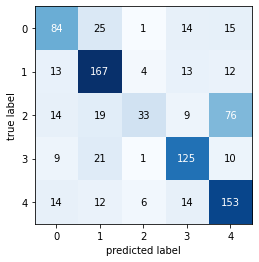

In [38]:
y_pred = evaluate_model(model)

The model's overall F1 score was `0.65` or ca. 65% accuracy. We'll use this as a benchmark to compare to as we make incremental progress in the following models.

In the next model, we'll tackle overfitting using a technique specific to deep learning models for computer vision applications. This approach involves generating new data (more images) by "augmenting" the existing samples. We accomplish this by applying a number of random transformations to the images in our dataset to produce more samples that appear new to the model. Our handy Keras `ImageDataGenerator` allows us to do just that while remaining consistent with our batched, pre-processed image pipeline.

## Using Image Augmentation
* The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: ImageDataGenerator. You will reuse it and apply it to the flower data set.
* Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
* Report the training and validation losses and accuracies and comment on the possible overfit.
* Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


In [39]:
# The data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In order to better understand each of the parameters in our datagen, here's a description provided to us by F. Chollet:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

#### Visualising the augmented images

With our datagen parameters specified, we have successfully completed the first step in our augmentation process. 

Let's visualise a set of our augmented images...

In [40]:
from keras.preprocessing import image

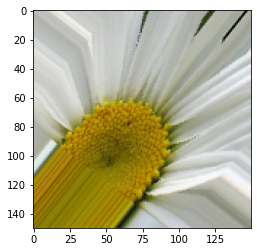

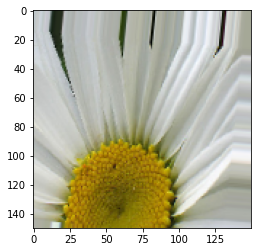

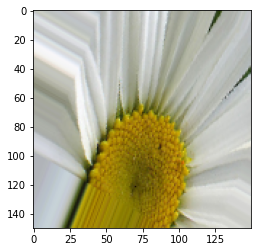

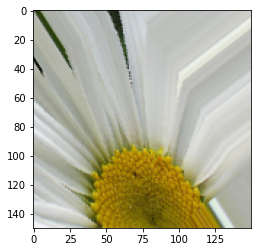

In [108]:
# Selecting the "daisy" class images from the training set
folder_path = 'src/flowers_split/train/daisy'
file_names = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
# We pick one image to "augment"
img_path = file_names[50]
# Read the image and resize it
img = image.load_img(img_path, target_size=target_size)
# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Great! We'll now be able to train our model on a larger dataset using more images like the samples above. However, there's still one extra step we must take to prevent overfitting. The input images, although augmented, are still heavily intercorrelated with the original dataset. In other words, most of the "new" information we've introduced is from our original data. To help address this issue, we add a Dropout layer to our model.

#### Training our model using data augmentation and dropout
To further fight overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier. Dropout is a regularization technique that helps prevent the model from overfitting by randomly "dropping" nuerons from the network in each training iteration. The goal of dropout is to encourage each hidden unit in the neural network to "learn" to work with a random set of surviving hidden units (neurons), creating a more robust network. This happens because each hidden unit must learn to encode a representation of the feature map without relying on other hidden units that might be "dropped" over the training iterations.

In [42]:
# Building our network (Conv2D/MaxPooling2D stack + Dropout + Dense/Flatten layer)
def build_network():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # This converts our 3-D feature maps into 1-D feature vectors
    model.add(layers.Flatten())
    # Here we set our dropout rate to 0.2
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    print(model.summary())
    # Setting learning rate manually
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(learning_rate=1e-5), 
                  #optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics =['categorical_accuracy'])
    return model

In [43]:
model = build_network()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

#### Training the model

We'll now train our updated model on the augmented images and visualise our training performance. Since we want to increase the number of samples seen by our model, we will train our model for 100 epochs (up from 20). This will allow our datagen to generate more augmented samples than previously seen in the original, unmodified set.

In [44]:
import time
def train_model(model, epochs=100):
    start_time = time.time()
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
    # Note that validation data shouldn't be augmented
    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size))
    print('Total training time (sec):', time.time() - start_time)
    plot_history(history)

Found 2590 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
21/21 [==============================] - 21s 942ms/step - loss: 1.6016 - categorical_accuracy: 0.2513 - val_loss: 1.5848 - val_categorical_accuracy: 0.2607
Epoch 2/100
21/21 [==============================] - 19s 909ms/step - loss: 1.5827 - categorical_accuracy: 0.3129 - val_loss: 1.5675 - val_categorical_accuracy: 0.2885
Epoch 3/100
21/21 [==============================] - 19s 916ms/step - loss: 1.5657 - categorical_accuracy: 0.3126 - val_loss: 1.5458 - val_categorical_accuracy: 0.3071
Epoch 4/100
21/21 [==============================] - 19s 912ms/step - loss: 1.5416 - categorical_accuracy: 0.3368 - val_loss: 1.5163 - val_categorical_accuracy: 0.3407
Epoch 5/100
21/21 [==============================] - 19s 912ms/step - loss: 1.5142 - categorical_accuracy: 0.3656 - val_loss: 1.4830 - val_categorical_accuracy: 0.3859
Epoch 6/100
21/21 [==============================] - 19s 909ms/step - loss: 1.4887 - categorical_accuracy: 0.3912 - val_loss: 1.4488 - val_categorical_accuracy:

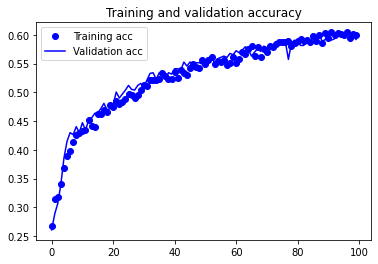

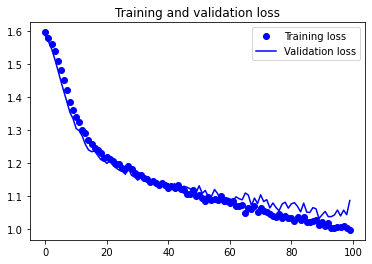

In [45]:
train_model(model, epochs=100)

### Evaluating model performance

In [46]:
def evaluate_model(model):  
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
    y_prob = model.predict_generator(test_generator, 
                                     np.ceil(test_generator.samples / test_generator.batch_size))
    # Select class label with highest probability
    y_pred = np.argmax(y_prob, axis=1)
    print('-'*10 + 'Classification Report' + '-'*5)
    print(classification_report(test_generator.classes, y_pred, target_names=classes))
    print('-'*10 + 'Confusion Matrix' + '-'*10)
    plot_confusion_matrix(confusion_matrix(test_generator.classes, y_pred))

Found 864 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


----------Classification Report-----
              precision    recall  f1-score   support

       daisy       0.63      0.58      0.60       139
   dandelion       0.73      0.61      0.67       209
        rose       0.66      0.44      0.53       151
   sunflower       0.53      0.88      0.66       166
       tulip       0.64      0.59      0.61       199

    accuracy                           0.62       864
   macro avg       0.64      0.62      0.61       864
weighted avg       0.64      0.62      0.62       864

----------Confusion Matrix----------


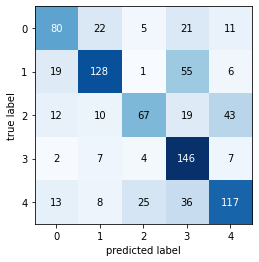

In [47]:
evaluate_model(model)

While the augmented images didn't seem to improve the model's F1 score, our model's training curves indicate that we are no longer overfitting. In other words, our training curve more closely matches the validation curve. In the next section of this notebook, we will be improving the accuracy of our classifier with a pre-trained model via a technique called _transfer learning_.

## Using a Pretrained Convolutional Base
A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A _pretrained network_ is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. (F. Chollet, Ch. 5.3 - Deep Learning with Python). What makes the use of pretrained convolutional bases desirable is that these networks are often trained on large enough datasets (e.g. ImageNet's 1.4 mil. labeled images of 1,000 classes) that the pretrained network's learned representations can encompass a general enough model of the visual world. Through _feature extraction_ and _fine-tuning_ techniques, we can "port" the learned features of the pretrained convbases across other models, such as our own. In the next section of this notebook, we'll be exploring the InceptionV3 pretrained convolutional base and applying it to our own model using a feature extraction approach.

### Feature extraction without data augmentation
* Build a network that consists of the Inception V3 convolutional base and two dense layers. As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.
* Train your network and report the training and validation losses and accuracies.
* Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [48]:
# Model parameters
epochs = 20
batch_size = 128
target_size = (150, 150)

Our first step is to select a pretrained network. For this task, we will use Google's [InceptionV3](https://en.wikipedia.org/wiki/Inceptionv3). This is a Keras image classification model that has been optionally loaded with weights pre-trained on the ImageNet dataset. The InceptionV3 is referred to as our "convolutional base". Note that the densely-connected classifier of the InceptionV3 has been removed (with parameter `include_top=False`). The reason for this decision is that our pretrained network's output, the densely-connected prediction layer, is not usable for our task specific to classifying a subset of five flower types. The ImageNet dataset used to train the InceptionV3 consists of 1,000 unique classes, and thus we will not have any use for the majority of the model's output tensors (the distinct classes' probability distributions). 

Thankfully, Keras provides us with a simple way to leave this part of the model out. Instead, we will be preserving layers that come earlier in the InceptionV3 which extract local, highly generic feature maps (such as visual edges, colors, and textures).

In [49]:
# Importing the pretrained network as a Keras model
from tensorflow.keras.applications import InceptionV3

In [50]:
# Initialising our conv_base object with desired parameters
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

87916544/87910968 [==============================] - 0s 0us/step


Let's look at the architecture of our convolutional base in detail...

In [51]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Now we'll check the last layer in our convolutional base. It's input shape will become our input shape for the Keras `Sequential` model.

In [52]:
conv_output_shape = conv_base.layers[-1].output_shape[1:]
print(conv_output_shape)

(3, 3, 2048)


### Performing feature extraction
We'll be covering two techniques to utilise our `conv_base` pretrained model. The first, demonstrated below, runs the convolutional base over our dataset, recording its output to Numpy arrays on disk. The resulting output, our image features, will be generated by calling the `predict` method of the `conv_base` model. This will serve as input to a standalone densely-connected classifier. While this first technique is computationally cheap to run, we will not be able to levarage data augmentation.

In [53]:
from pathlib import Path

In [54]:
def count_files(path, extension):
    directory = Path(path)
    return len(list(directory.glob('**/*.{extension}'.format(extension=extension))))

In [55]:
def extract_features(directory):
    sample_count = count_files(directory, 'jpg')
    features = np.zeros(shape=(sample_count, *conv_output_shape))
    labels = np.zeros(shape=(sample_count, len(classes)))
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        classes=classes,
        target_size=train_generator.target_size,
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features.reshape(-1, np.prod(conv_output_shape)), labels

In [56]:
x_train, y_train = extract_features(train_dir)
x_val, y_val = extract_features(validation_dir)
x_test, y_test = extract_features(test_dir)

Found 2590 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 864 images belonging to 5 classes.


### Building our model

In [57]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_dim=np.prod(conv_output_shape)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(classes), activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(learning_rate=1.5e-6),
                  metrics =['categorical_accuracy'])
    return model

In [58]:
model = build_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 9,440,261
Trainable params: 9,440,261
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
def train_model(model, x_train, y_train, batch_size, epochs):
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val)
    )  
    plot_history(history)

Epoch 1/120
21/21 [==============================] - 1s 25ms/step - loss: 2.9395 - categorical_accuracy: 0.2490 - val_loss: 1.6137 - val_categorical_accuracy: 0.3662
Epoch 2/120
21/21 [==============================] - 0s 12ms/step - loss: 2.2237 - categorical_accuracy: 0.3449 - val_loss: 1.3728 - val_categorical_accuracy: 0.4484
Epoch 3/120
21/21 [==============================] - 0s 13ms/step - loss: 1.9830 - categorical_accuracy: 0.3764 - val_loss: 1.2408 - val_categorical_accuracy: 0.4959
Epoch 4/120
21/21 [==============================] - 0s 12ms/step - loss: 1.7783 - categorical_accuracy: 0.4306 - val_loss: 1.1490 - val_categorical_accuracy: 0.5365
Epoch 5/120
21/21 [==============================] - 0s 12ms/step - loss: 1.5726 - categorical_accuracy: 0.4829 - val_loss: 1.0828 - val_categorical_accuracy: 0.5736
Epoch 6/120
21/21 [==============================] - 0s 13ms/step - loss: 1.4134 - categorical_accuracy: 0.5195 - val_loss: 1.0380 - val_categorical_accuracy: 0.5898
Epoc

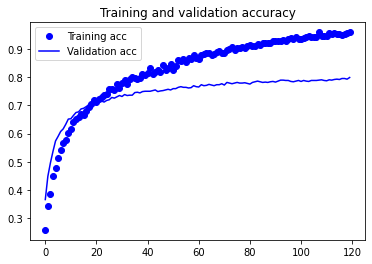

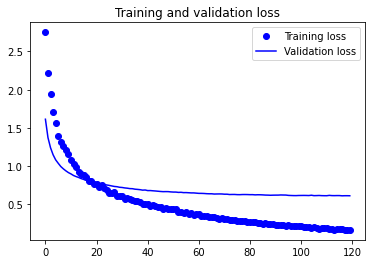

In [60]:
train_model(model, x_train, y_train, batch_size, epochs=120)

In [61]:
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


----------Classification Report-----
              precision    recall  f1-score   support

       daisy       0.82      0.81      0.81       139
   dandelion       0.89      0.87      0.88       209
        rose       0.77      0.74      0.75       151
   sunflower       0.87      0.81      0.84       166
       tulip       0.75      0.85      0.80       199

    accuracy                           0.82       864
   macro avg       0.82      0.81      0.82       864
weighted avg       0.82      0.82      0.82       864

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f62f2d93cd0>)

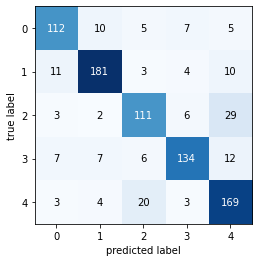

In [62]:
print('-'*10 + 'Classification Report' + '-'*5)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=classes))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

### Feature extraction with data augmentation
* Modify your program to include an image transformer. Train a new model.
* Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

**WARNING**: "This technique is so expensive that you should only attempt it if you have access to a GPU–it's absolutely intractable on CPU. If you can't run your code on GPU, then the previous technique is the way to go" (F. Chollet, p.149).

Thankfully, Google provides us free access to a Tesla K80 GPU or equivalent on the Colab platform. To enable GPU hardware acceleration, go to `Edit > Notebook settings` and select `GPU` as our `Hardware accelerator`. 

We can verify that our GPU is connected with the following script:

In [63]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

If you see a device name after running the above, you're good to go!

In [64]:
epochs = 20
batch_size = 128
target_size = (150, 150)

In [65]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

### Building our model
In this technique, we will be extending our model using the `conv_base` as a layer in our network. We can do so by adding `Dense` layers on top and running the whole thing end-to-end on the input data. This technique allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

Before we compile and train our model, we have to freeze the pretrained network weights. In other words, we want to prevent the `conv_base` weights from being updated during the training process. This is an important step since the use of randomly-initialised `Dense` layers would propagate very large weight updates through the network, effectively destroying the representations previously learned (Chollet, p.150).

In [66]:
# Freeze pretrained network weights
conv_base.trainable = False

In [67]:
def build_model(conv_base):
    model3 = models.Sequential()
    model3.add(conv_base)
    #model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model3.add(layers.Flatten())
    model3.add(layers.Dropout(0.2))
    #model3.add(layers.Dense(512, activation='relu'))
    #model3.add(layers.Dropout(0.2))
    #model3.add(layers.Dense(512, activation='relu'))
    #model3.add(layers.Dropout(0.2))
    #model3.add(layers.Dense(128, activation='relu'))
    #model3.add(layers.Dropout(0.2))
    model3.add(layers.Dense(64, activation='relu'))
    model3.add(layers.Dense(len(classes), activation='softmax'))
    model3.compile(loss='categorical_crossentropy', 
                      optimizer=optimizers.RMSprop(learning_rate=1e-4),
                      metrics =['categorical_accuracy'])
    return model3

In [68]:
model = build_model(conv_base)

In [69]:
def train_model(model, epochs=1):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
    # Note that validation data shouldn't be augmented
    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical'
    )
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size))
    plot_history(history)

Found 2590 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
21/21 [==============================] - 32s 1s/step - loss: 1.9633 - categorical_accuracy: 0.4219 - val_loss: 0.9103 - val_categorical_accuracy: 0.6419
Epoch 2/30
21/21 [==============================] - 19s 922ms/step - loss: 0.8563 - categorical_accuracy: 0.6613 - val_loss: 0.7963 - val_categorical_accuracy: 0.6860
Epoch 3/30
21/21 [==============================] - 19s 925ms/step - loss: 0.7653 - categorical_accuracy: 0.7012 - val_loss: 0.7185 - val_categorical_accuracy: 0.7358
Epoch 4/30
21/21 [==============================] - 20s 949ms/step - loss: 0.6763 - categorical_accuracy: 0.7325 - val_loss: 0.6431 - val_categorical_accuracy: 0.7555
Epoch 5/30
21/21 [==============================] - 20s 953ms/step - loss: 0.6222 - categorical_accuracy: 0.7737 - val_loss: 0.6396 - val_categorical_accuracy: 0.7717
Epoch 6/30
21/21 [==============================] - 20s 944ms/step - loss: 0.6140 - categorical_accuracy: 0.7770 - val_loss: 0.6381 - val_categorical_accuracy: 0.7555
E

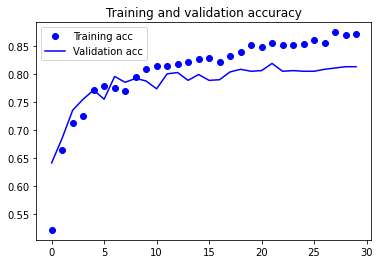

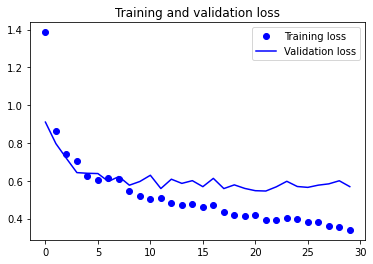

In [70]:
train_model(model, epochs=30)

### Evaluating model performance

In [71]:
def evaluate_model(model):  
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
    y_prob = model.predict_generator(test_generator, np.ceil(test_generator.samples / test_generator.batch_size))
    y_pred = np.argmax(y_prob, axis=1)
    print('-'*10 + 'Classification Report' + '-'*5)
    print(classification_report(test_generator.classes, y_pred, target_names=classes))
    print('-'*10 + 'Confusion Matrix' + '-'*10)
    plot_confusion_matrix(confusion_matrix(test_generator.classes, y_pred))

Found 864 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


----------Classification Report-----
              precision    recall  f1-score   support

       daisy       0.83      0.87      0.85       139
   dandelion       0.86      0.88      0.87       209
        rose       0.76      0.77      0.77       151
   sunflower       0.82      0.85      0.84       166
       tulip       0.88      0.81      0.85       199

    accuracy                           0.84       864
   macro avg       0.83      0.84      0.84       864
weighted avg       0.84      0.84      0.84       864

----------Confusion Matrix----------


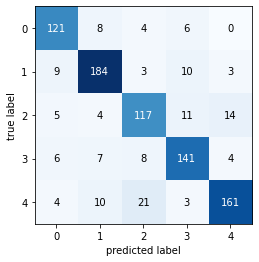

In [72]:
evaluate_model(model)

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 22,982,821
Trainable params: 1,180,037
Non-trainable params: 21,802,784
_________________________________________________________________


### Fine-tuning
Fine-tuning refers to the unfreezing of a few layers in the `conv_base` frozen model base. We choose to unfreeze the layers which encode more specialised features. These layers in the `InceptionV3` are at the top of the network.

**Warning**: Before we proceed, make sure that you have already trained your fully-connected classifier from above. 

To further clarify, we will be re-purposing the `InceptionV3` pre-trained model by fine-tuning the layers in the base. We already removed the convolutional base's original classifier by setting `include_top=False`, which allowed us to use only the layers in the base which contained abstract representations of features useful for general image classification tasks. We then added our own fully-connected classifier to the network that allowed us to restrict the predictions to our specific problem domain (predicting the five classes of the flowers dataset). In order to preserve the `InceptionV3`'s learned weight values, we set `conv_base.trainable = False`. This step froze all the pre-trained model layers and kept their weight values the same during the training process. Now, we want to fine-tune our pre-trained model by setting some of the `conv_base` top layers to `layer.trainable = True`. We choose to unfreeze the higher layers whose specific features are said to be problem dependendent, as opposed to the lower layers whose general features are problem independent. 

The figure below illustrates the two strategies we use in this notebook.


![Figure 1. Fine-tuning strategies.](figures/2019-11-22-Convolutional-Neural-Networks-figure-1.jpg)

Strategy 2 was used previously to train only the fully-connected layers, while Strategy 3 will now be used to train both the fully-connected layers and some of the `InceptionV3` top layers.

To help you choose which of the three transfer learning strategies is best for your specific dataset, you can refer to the following _size-similarity matrix_.


![Figure 2. Size-similarity matrix.](figures/2019-11-22-Convolutional-Neural-Networks-figure-2.jpg)


Since we started off with a relatively small dataset, we chose Strategy 2 (Quadrant IV–small dataset, similar to pre-trained model dataset). We removed the original output layer from the `InceptionV3` and ran the pre-trained model as a fixed feature extractor. The resulting features were used to train a new classifier, the fully-connected classifier we created in the previous model. In the model below, we will be assuming a balance between Quadrants I and III (small dataset, somewhat dissimilar to pre-trained model dataset).

In [75]:
import keras

In [84]:
print('Num layers in InceptionV3 base:', len(conv_base.layers))

Num layers in InceptionV3 base: 311


In [98]:
conv_base.trainable = True

In [99]:
### Fine-tuning
# set all layers trainable by default
for layer in conv_base.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
# fix deep layers (fine-tuning only last 50 layers)
for layer in conv_base.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [100]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

We will be using the `RMSprop` optimiser with a very low learning rate in order to limit the magnitude of the modifications made to the representations of the layers that we are fine-tuning. Updates that are too large might harm these representations (F. Chollet, p.178).

Found 2590 images belonging to 5 classes.
Found 863 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
21/21 [==============================] - 26s 983ms/step - loss: 0.5971 - categorical_accuracy: 0.8066 - val_loss: 0.5678 - val_categorical_accuracy: 0.8227
Epoch 2/100
21/21 [==============================] - 19s 927ms/step - loss: 0.5228 - categorical_accuracy: 0.8208 - val_loss: 0.5713 - val_categorical_accuracy: 0.8088
Epoch 3/100
21/21 [==============================] - 20s 932ms/step - loss: 0.4591 - categorical_accuracy: 0.8457 - val_loss: 0.5691 - val_categorical_accuracy: 0.8134
Epoch 4/100
21/21 [==============================] - 20s 932ms/step - loss: 0.4504 - categorical_accuracy: 0.8404 - val_loss: 0.5643 - val_categorical_accuracy: 0.8146
Epoch 5/100
21/21 [==============================] - 20s 935ms/step - loss: 0.4280 - categorical_accuracy: 0.8486 - val_loss: 0.5726 - val_categorical_accuracy: 0.8065
Epoch 6/100
21/21 [==============================] - 20s 931ms/step - loss: 0.3871 - categorical_accuracy: 0.8795 - val_loss: 0.5663 - val_categorical_accuracy:

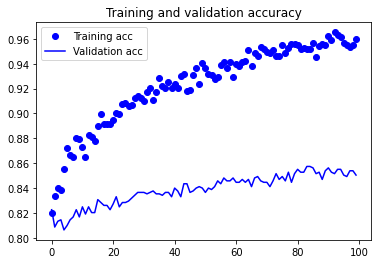

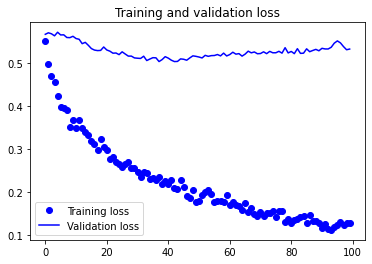

In [101]:
### Re-training model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics =['categorical_accuracy'])
train_model(model, epochs=100)

Found 864 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


----------Classification Report-----
              precision    recall  f1-score   support

       daisy       0.86      0.84      0.85       139
   dandelion       0.90      0.90      0.90       209
        rose       0.86      0.83      0.84       151
   sunflower       0.89      0.86      0.88       166
       tulip       0.84      0.90      0.87       199

    accuracy                           0.87       864
   macro avg       0.87      0.87      0.87       864
weighted avg       0.87      0.87      0.87       864

----------Confusion Matrix----------


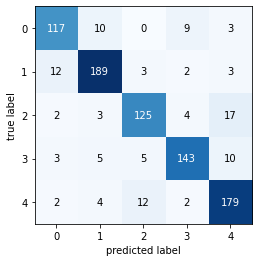

In [102]:
### Evaluating model performance
evaluate_model(model)

Great news–we were able to improve our model's F1 score ~3% by fine-tuning our pre-trained convolutional base. Unfreezing some of the layers in the base let us successfully repurpose the pre-trained model weights to better fit our task. Let's save our final model and call it a day! Thanks for sticking around this far.

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 22,982,821
Trainable params: 1,180,037
Non-trainable params: 21,802,784
_________________________________________________________________


## Credits
This assignment was prepared by P. Nugues et al., HT2019 (link [here](https://web.archive.org/web/20200111075049/http://cs.lth.se/edan95/lab-programming-assignments/lab-session-3/)).

Most of the inspiration for this notebook came from François Chollet, creator of Keras and author of Deep Learning with Python. His version of this task is found in notebooks [5.2-using-convnets-with-small-datasets.ipynb](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.2-using-convnets-with-small-datasets.ipynb) and [5.3-using-a-pretrained-convnet.ipynb](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb). Another version can be found on the TensorFlow Guide blog [here](https://www.tensorflow.org/guide/keras/transfer_learning). 

Pedro Marcelino helped inspire Figures 1 and 2 in Fine-tuning, link to his article [here](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751). Also, special thanks to Alexander Maemev on Kaggle for the Flowers Recognition dataset used in this task, available publicly at the link [here](https://www.kaggle.com/alxmamaev/flowers-recognition).